parent: Preselection_v6

In [1]:
import os, sys
import numpy as np
import pickle
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import json
import ROOT as rt
import fnmatch

## user define
sys.path.append('.')
sys.path.append('./Utils')
from Plotter import HistStack
from LoadData import *
from SystHelper import *
from beeps import *

Welcome to JupyROOT 6.28/00


# Set config

In [2]:
# ERA="ee17"
# ERA="ee16pre"
# # ERA="mm18"
# ERA="em18"
# # DATE = '20230129_17_eleffmva'
# DATE = '20230301_18'
# # DATE = '20230130_18_dyhighworctight'
# # INPUTDIR = "/eos/user/h/hkwon/Run2/20230130_18_dyhighworctight/mm/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/20230301_18/em/"
import sys
ERA = sys.argv[1]
DATE = sys.argv[2]
INPUTDIR = sys.argv[3]
PART = sys.argv[4]
REGION = sys.argv[5]

DUMP_PKL = False
DRAW_SR = True
RUN_SIDEBAND_MET = False
RUN_SIDEBAND_MASS = False
RUN_SIDEBAND_PT = False
DUMP_SIDEBAND_MET_PKL = False
DUMP_SIDEBAND_MASS_PKL = False
DUMP_SIDEBAND_PT_PKL = False
RUN_BTAG = True
EXPORT_VARIABLE = False

# # for dev
# ERA = "em18"
# DATE = "20230819lep_18"
# # INPUTDIR = "/eos/user/h/hkwon/SWAN_projects/Zpeak/20230622jer_18/Presel"
# INPUTDIR = "/eos/user/h/hkwon/SWAN_projects/Zpeak/20230819lep_18/Presel/DUMP"
# # INPUTDIR = "/eos/user/h/hkwon/Run2/Preselection/20230819lep/Presel/DUMP"
# PART = "btest"

# Load data

In [3]:
dic_df_raw, dic_nested_shape_sys = get_dic_raw_sys(ERA, INPUTDIR, REGION)

In [4]:
dic_df_raw['TT'].columns

Index(['PuppiMET_pre', 'mass_pre', 'pt_lead_pre', 'pt_trail_pre', 'U_pre',
       'JZB_pre', 'dPhill_pre', 'dPhilMET_pre', 'MT_pre', 'MT2_pre',
       ...
       'weighteffrecoSFUp', 'weighteffrecoSFDown', 'weighttopSFUp',
       'weighttopSFDown', 'weightgenweightUp', 'weightgenweightDown',
       'weighttrigSFUp', 'weighttrigSFDown', 'weightbtagSFUp',
       'weightbtagSFDown'],
      dtype='object', length=204)

In [5]:
# get x-sec
dic_xsec={}
with open('config/CrossSection.json') as json_file:
    data = json.load(json_file)
    dic_xsec=data
print(dic_xsec)

{'Data': 1, 'DY': 6077.22, 'DY500To700': 0.2558, 'DY700To800': 0.04023, 'DY800To1000': 0.03406, 'DY1000To1500': 0.01828, 'DY1500To2000': 0.002367, 'DY2000To3000': 0.0005409, 'TT': 88.29, 'TTUp': 88.29, 'TTDown': 88.29, 'TThdampUp': 88.29, 'TThdampDown': 88.29, 'TTSemi': 365.34, 'TTZ': 0.2432, 'top': 34.91, 'antitop': 34.91, 'WW': 12.82, 'WZ': 5.23, 'WZQQ': 6.42, 'ZZ': 0.6008, 'WWW': 0.0072, 'WWZ': 0.1707, 'HWW': 0.31, 'H': 2.78, 'Zp-1700_CH-345': 0.03523, 'Zp-1700_CH-595': 0.03523, 'Zp-1700_CH-845': 0.03523, 'Zp-2100_CH-345': 0.01198, 'Zp-2100_CH-595': 0.01198, 'Zp-2100_CH-845': 0.01198, 'Zp-2500_CH-345': 0.004396, 'Zp-2500_CH-595': 0.004396, 'Zp-2500_CH-845': 0.004396, 'Zp-2500_CH-1095': 0.004396, 'Zp-2900_CH-345': 0.001768, 'Zp-2900_CH-595': 0.001768, 'Zp-2900_CH-845': 0.001768, 'Zp-2900_CH-1095': 0.001768, 'Zp-2900_CH-1345': 0.001768, 'Zp-3300_CH-345': 0.000729, 'Zp-3300_CH-595': 0.000729, 'Zp-3300_CH-845': 0.000729, 'Zp-3300_CH-1095': 0.000729, 'Zp-3300_CH-1345': 0.000729, 'Zp-3300

# Draw

In [6]:
# draw
# get plot configuration
dic_variable={
    "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
    "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
    "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],
    "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
    "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
    "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
    "U_pre": [14, 0, 660, "U [GeV]"],
    "JZB_pre": [24, -600, 600, "JZB"],
    "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
    "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
    "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
    "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
    "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
    "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
    "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    "nbjetflav_pre": [7, 0, 7, "N bjet"],     
    # "njet_pre": [10, 0, 10, "N jet"],  
# # #     "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# # #     "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"],   
# # #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
# # #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
# # #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"],  
#     "HT_pre": [14, 0, 660, "HT [GeV]"],       
}

#temp, overwrite!
# dic_variable={
#     "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#     "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],   
#     "nbjetflav_pre": [7, 0, 7, "N bjet"],          
# }


# if "em" in ERA:
#     dic_variable["pt_el_pre"] = [15, 20,  660, "p_{T}(e) [GeV]"]
#     dic_variable["pt_mu_pre"] = [15, 20,  660, "p_{T}(#mu) [GeV]"]
    
# partition
if PART=="one":
    dic_variable={
        "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
        "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
        "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],
        "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
        "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
        "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
        "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    }  
#     if "em" in ERA:
#         dic_variable["pt_el_pre"] = [15, 20,  660, "p_{T}(e) [GeV]"]
#         dic_variable["pt_mu_pre"] = [15, 20,  660, "p_{T}(#mu) [GeV]"]    
if PART=="two":
    dic_variable={
        "U_pre": [14, 0, 660, "U [GeV]"],        
        "JZB_pre": [24, -600, 600, "JZB"],         
        "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
        "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
        "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
        "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
        "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
        "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
        "nbjetflav_pre": [7, 0, 7, "N bjetflav"],     
        # "njet_pre": [10, 0, 10, "N jet"],    
    }      
if PART=="btest":
    dic_variable={  
    "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "nbjetflav_pre": [7, 0, 7, "N bjetflav"],     
#     "nbjetflav_jesup_pre": [7, 0, 7, "N bjetflav jesUp"],     
#     "nbjetflav_jesdown_pre": [7, 0, 7, "N bjetflav jesDown"],     
    }   
if PART=="DYMET":
    dic_variable={  
    "PuppiMET_pre": [18, 30, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "nbjetflav_pre": [7, 0, 7, "N bjetflav"],     
#     "nbjetflav_jesup_pre": [7, 0, 7, "N bjetflav jesUp"],     
#     "nbjetflav_jesdown_pre": [7, 0, 7, "N bjetflav jesDown"],     
    }   

# temp, overwrite!
# dic_variable={
#     "JZB_pre": [24, -600, 600, "JZB"],
#     # "dRllMET_pre": [30, 0, 6, "#DeltaR(ll,p_{T}^{miss}))"],
    
# }


print(dic_variable)
list_variables = [(key, dic_variable[key]) for key in dic_variable]
print(list_variables)

{'PuppiMET_pre': [14, 100, 660, 'Puppi p_{T}^{miss} [GeV]']}
[('PuppiMET_pre', [14, 100, 660, 'Puppi p_{T}^{miss} [GeV]'])]


In [7]:
from multiprocessing import Pool

def wrapper_mp(variable, r):
    
#     sys_list = ["wotop"] # other than 'weight'
#     for sys_key in sys_list:
#         os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+sys_key)
#         hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
#         c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+sys_key+"/preselv1_"+query_str, is_dnn=False) 
#     year = ERA.replace('mm', '')
#     year = year.replace('ee', '')
#     year = year.replace('em', '')
    
    os.system("mkdir -p "+out_dir)
    os.system("mkdir -p "+out_dir+"/sys")
    os.system("mkdir -p "+out_dir+"/AN")
#     sys_list1 = ["puweight", "l1prefiring", "effSF", "topSF"]
#     sys_list1 = ["puweight", "l1prefiring", "effSF"]
    threshold = 1
    if REGION=='SR' or REGION=='TR' or REGION=='METSB':
        if not 'phi' in variable and not 'eta' in variable:
    #         if not 'eta' in variable:
            threshold = 0.3
        if "PuppiMET_pre" in variable:
            threshold = 0.5
        if "nbjet" in variable:
            threshold = -0.2  
        if "JZB" in variable:
            threshold = 0 
    # draw plot with syst
#     dic_sys_sqr = draw_with_systematics(dic_df_raw, dic_nested_shape_sys, sys_list, variable, dic_variable[variable], REGION, threshold)
    file_prefix = out_dir
    sys_list = get_sys_list()
    dic_sys_sqr = get_dic_sys("Zp-2500_CH-345", ERA, dic_df_raw, dic_nested_shape_sys, sys_list, variable, dic_variable[variable], REGION, threshold, file_prefix, file_str=query_str)
    
    print("here", dic_sys_sqr)
    
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3], dic_sys=dic_sys_sqr)      
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=out_dir+"/AN/systall_"+query_str, blind_from=threshold)   
    return None

{'metUp': array([4.32403394e+02, 3.09288786e+02, 1.48783789e+02, 6.46016094e+01,
       2.94026650e+01, 1.59485914e+01, 6.01767365e+00, 7.94530231e+00,
       2.99683596e+00, 1.29390744e+00, 8.89773024e-01, 3.58970460e-01,
       7.86142085e-01, 1.01586516e+00]), 'metDown': array([-4.57967500e+02, -3.01508656e+02, -1.31044043e+02, -6.04013277e+01,
       -2.77342344e+01, -1.67948326e+01, -6.00896141e+00, -4.30581101e+00,
       -3.06796940e+00, -7.41002802e-01, -1.30067851e+00, -1.18881918e+00,
        1.61651897e-03, -9.92638685e-01]), 'jesUp': array([ 4.19034209e+00,  1.88832303e+00,  8.03255974e-01,  2.05611719e-01,
        6.92358454e-02,  6.94586557e-02,  6.07594656e-02,  2.65753426e-02,
       -2.76793144e-02,  3.74213161e-03,  1.31970627e-02, -1.00760501e-03,
        1.05735878e-04, -9.37195157e-03]), 'jesDown': array([-4.52916667e+00, -1.35355128e+00, -2.38407312e-01, -1.92460329e-01,
       -1.64024914e-01,  1.99953082e-02, -2.39701991e-02, -1.38844435e-03,
       -2.35737594e

       2.73750548e-03, 1.40407066e+00])}
here {'metUp': array([1.86972695e+05, 9.56595531e+04, 2.21366158e+04, 4.17336793e+03,
       8.64516706e+02, 2.54357568e+02, 3.62123961e+01, 6.31278288e+01,
       8.98102580e+00, 1.67419645e+00, 7.91696035e-01, 1.28859791e-01,
       6.18021991e-01, 1.03198202e+00]), 'metDown': array([2.09734231e+05, 9.09074699e+04, 1.71725413e+04, 3.64832038e+03,
       7.69187755e+02, 2.82066401e+02, 3.61076172e+01, 1.85400084e+01,
       9.41243625e+00, 5.49085153e-01, 1.69176458e+00, 1.41329104e+00,
       0.00000000e+00, 9.85331558e-01]), 'metjerUp': array([6.76041331e+02, 3.03339925e+04, 5.94256739e+03, 1.43166672e+03,
       1.82046015e+02, 1.07188585e+02, 4.73770954e+00, 2.73609716e+01,
       1.22220724e+01, 0.00000000e+00, 0.00000000e+00, 1.28325934e+00,
       4.43914208e-02, 8.38505085e-02]), 'metjerDown': array([2.09734231e+05, 9.09074699e+04, 1.71725413e+04, 3.64832038e+03,
       7.69187755e+02, 2.82066401e+02, 3.61076172e+01, 1.85400084e+01,
   

Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/sys/systUp_metmass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/sys/systUp_metmass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/sys/systDown_metmass_pre>1

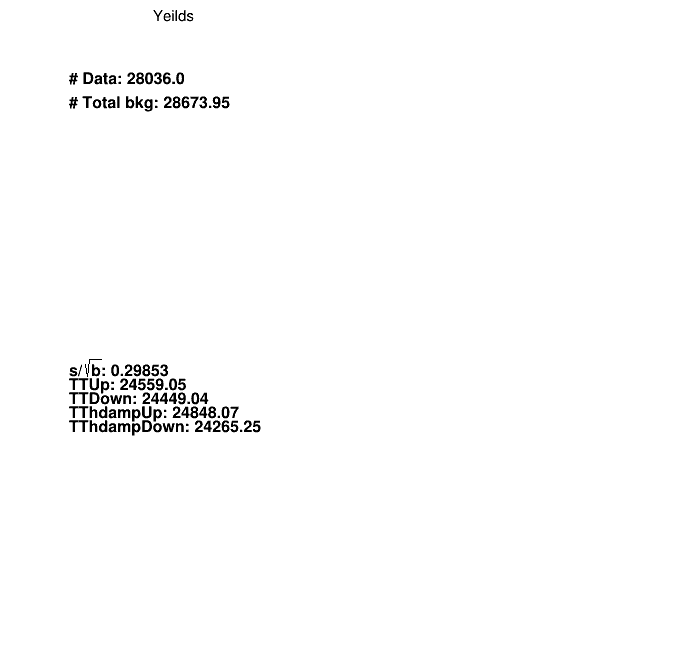

In [8]:
query_str = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"

if DRAW_SR:
    out_dir = DATE+"/Presel/DRAW/"+ERA+"/"+REGION
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables) 
#     wrapper_mp('mass_pre', [45, 100, 1000, 'M_{ll} [GeV]'])

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=out_dir+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=out_dir+"/pie_"+query_str)

In [9]:
# ###### wotop ######
# dic_variable={
#     "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#     "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"], 
# }
# os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wotop")

# for variable, r in dic_variable.items():
#     if not "Puppi" in variable:
#         threshold = 0.3
#     else:
#         threshold = 0.5
#     hist=HistStack(dic_df_raw, variable, "weight", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_"+query_str, blind_from=threshold)        
#     hist=HistStack(dic_df_raw, variable, "weighthdampUp", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampUp"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weighthdampDown", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_hdampDown"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weightPSUp", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEUp"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "weightPSDown", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_UEDown"+query_str, blind_from=threshold)
#     hist=HistStack(dic_df_raw, variable, "wotop", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/norm_"+query_str, blind_from=threshold) 
# hist.get_yeilds()
# hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/pie_"+query_str)  

In [10]:
# ###### wobsf ######
# dic_variable={
#     "nbjetflav_pre": [10, 0, 10, "N bjetflav"],     
#     "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
# }
# os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wobsf")

# for variable, r in dic_variable.items():
#     if not "Puppi" in variable:
#         threshold = 0.3
#     else:
#         threshold = 0.5
#     hist=HistStack(dic_df_raw, variable, "weight", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/normblind_"+query_str, blind_from=threshold)        
#     hist=HistStack(dic_df_raw, variable, "wobsf", r[0], r[1], r[2], r[3])  
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wobsf/norm_"+query_str, blind_from=threshold) 

# Signal Acc x Eff x presel

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230819lep_18/Presel/DRAW/em18/SR/sig_eff.pdf has been created


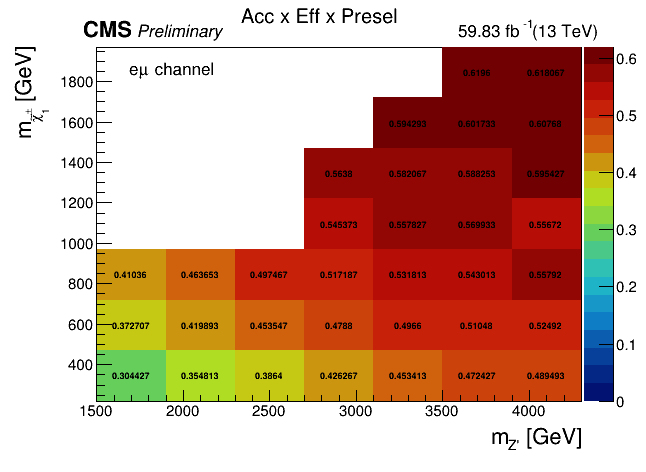

In [11]:
str_channel, str_lumi = HistStack.get_str_lumi_channel(ERA, ERA)

Zp_mass=[1700, 2100, 2500, 2900, 3300, 3700, 4100]
CH_mass=[345, 595, 845, 1095, 1345, 1595, 1845]
c1=rt.TCanvas("c1", "c1", 650, 500)
c1.SetLeftMargin(0.15)
c1.SetBottomMargin(0.15)
h2d1=rt.TH2D("h2d1", "", len(Zp_mass), Zp_mass[0]-200, Zp_mass[-1]+200, len(CH_mass), CH_mass[0]-125, CH_mass[-1]+125)
h2d1.SetTitle("Acc x Eff x Presel")

n_sig_in = 150000/4
if "em" in ERA:
    n_sig_in = 150000/2

for key in dic_df_raw:
    if not "Zp" in key:
        continue
    tmp=key.replace('_', '-')
    tmp=tmp.split('-')
    
    MZp=tmp[1]
    MCH=tmp[3]
    binx=Zp_mass.index(int(MZp))+1
    biny=CH_mass.index(int(MCH))+1
    h2d1.SetBinContent(binx, biny, dic_df_raw[key].shape[0]/(n_sig_in))
# # missing bin by hand
# h2d1.SetBinContent(5, 3, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000
# h2d1.SetBinContent(3, 4, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000

# set_palette("rainbow",255)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetPalette(55)

h2d1.Draw("colz text")
h2d1.SetYTitle("m_{#tilde#chi_{1}^{#pm}} [GeV]")
h2d1.SetXTitle("m_{Z'} [GeV]")
h2d1.GetYaxis().SetTitleSize(0.05)
h2d1.GetXaxis().SetTitleSize(0.05)
latex=rt.TLatex()
latex.DrawLatexNDC( 0.2,0.84, "#scale[0.8]{#font[42]{"+str_channel+" channel}}")

latex1=rt.TLatex()
latex1.DrawLatexNDC(0.71, 0.92, "#font[42]{#scale[0.8]{"+str_lumi+" fb^{-1}(13 TeV)}}");
latex1.DrawLatexNDC(0.13, 0.92, "#font[62]{CMS}#font[42]{#it{#scale[0.8]{ Preliminary}}}");
 
c1.Draw()
c1.SaveAs(out_dir+"/sig_eff.pdf")